# Submission details
### Name: EMMANUEL KWAME ASIEDU
### ID: 24259805
### Class code: MEEE

In [1]:
#Imports
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from skimage import morphology
from skimage.morphology import skeletonize,remove_small_objects,remove_small_holes
from skimage.util import img_as_ubyte
from skimage.measure import label, regionprops
from scipy.stats import mode
# Calculate mode box size
from collections import Counter

In [12]:
#function calls
#os.chdir('/home/emmanuel-k-asiedu/NotDesktop/Virtual-Spaces/jnotebooks/docu/Assignments-Univesity_of_Galway/Mini_Project/images/set_2')
def load_path(folder_name):
    """
    Change the current working directory to the specified folder.
    """
    path = f'/home/emmanuel-k-asiedu/NotDesktop/Virtual-Spaces/jnotebooks/docu/Assignments-Univesity_of_Galway/Mini_Project/images/{folder_name}'
    os.chdir(path)

# Function to load and display the image
def load_image(image_in_sequence):
    folder_dict = {
        "set_1": ["1.jpg", "2.png", "3.png", "4.jpg"],
        "set_2": ["1.png", "2.jpg", "3.jpg"],
        "set_3": ["1.png", "2.png", "3.png"]
    }

    image_list = []
    for folder, images in folder_dict.items():
        for image in images:
            image_list.append((folder, image))
    
    if 1 <= image_in_sequence <= len(image_list):
        # Get the folder and image
        folder, image_file = image_list[image_in_sequence - 1]
        load_path(folder)
        
        img = cv2.imread(image_file)
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        return img

    else:
        print("Invalid sequence number. Please provide a number within the valid range.")
    

def plot_image(image):
    #plt.title(title, size=20)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
def calculate_mode(sizes):
    size_counts = Counter(sizes)
    mode_size = max(size_counts, key=size_counts.get)
    return mode_size

def rotate_image(image,angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    angle = 18 
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, rotation_matrix, (w, h))

def test_detection(regions,):
    #original_image = image.copy()
    # Extract box sizes and coordinates
    box_data = []
    for region in regions:
        min_row, min_col, max_row, max_col = region.bbox
        width = max_col - min_col
        height = max_row - min_row
        box_data.append({"coordinates": (min_row, min_col, max_row, max_col), 
                        "width": width, "height": height})

    # Calculate mode box size
    widths = [box["width"] for box in box_data]
    heights = [box["height"] for box in box_data]
    mode_width = calculate_mode(widths)
    mode_height = calculate_mode(heights)
    #mode_width = mode(widths).mode[0]
    #mode_height = mode(heights).mode[0]

    # Define range for valid box sizes
    width_range = (mode_width - 10, mode_width + 10)
    height_range = (mode_height - 10, mode_height + 10)

    # Adjust boxes
    updated_boxes = []
    for box in box_data:
        min_row, min_col, max_row, max_col = box["coordinates"]
        width = box["width"]
        height = box["height"]

        if not (width_range[0] <= width <= width_range[1]) or not (height_range[0] <= height <= height_range[1]):
            # Replace with mode size
            max_row = min_row + mode_height
            max_col = min_col + mode_width

        updated_boxes.append({"coordinates": (min_row, min_col, max_row, max_col), 
                            "width": max_col - min_col, 
                            "height": max_row - min_row})

    
    for idx, box in enumerate(updated_boxes):
        print(f"Box {idx}: Coordinates {box['coordinates']}, Width {box['width']}, Height {box['height']}")

    return box_data,width_range,height_range,mode_height,mode_width
    

def corrected_rectangle(image, edges, subtracted_edges,threshold_multiplier,sign,box_data,width_range,height_range,mode_height,mode_width):
    
    updated_boxes = []
    for box in box_data:
        min_row, min_col, max_row, max_col = box["coordinates"]
        width = box["width"]
        height = box["height"]

        if not (width_range[0] <= width <= width_range[1]) or not (height_range[0] <= height <= height_range[1]):
            
            max_row = min_row + mode_height
            max_col = min_col + mode_width

        updated_boxes.append({"coordinates": (min_row, min_col, max_row, max_col), 
                            "width": max_col - min_col, 
                            "height": max_row - min_row})

    
    dynamic_threshold_multiplier = threshold_multiplier

    
    edge_counts = []
    for box in updated_boxes:
        min_row, min_col, max_row, max_col = box["coordinates"]
        roi = subtracted_edges[min_row:max_row, min_col:max_col]
        edge_counts.append(cv2.countNonZero(roi))

    avg_edge_count = np.mean(edge_counts)
    MIN_EDGE_THRESHOLD = avg_edge_count * dynamic_threshold_multiplier

    
    rectangle_status = {}

    
    canny_image_with_rectangles = edges.copy()
    rgb_image_with_overlay = image.copy()

    for idx, box in enumerate(updated_boxes):
        min_row, min_col, max_row, max_col = box["coordinates"]
        roi = subtracted_edges[min_row:max_row, min_col:max_col]
        
        # Count edges
        edge_count = cv2.countNonZero(roi)
        if sign == 0:
            is_occupied = edge_count < MIN_EDGE_THRESHOLD
        else:
            is_occupied = edge_count > MIN_EDGE_THRESHOLD
        status = "Occupied" if is_occupied else "Free"
        
        
        rectangle_status[idx] = {
            "coordinates": (min_col, min_row, max_col, max_row),
            "edge_count": edge_count,
            "status": status
        }
        
        # Draw on images
        color = (255, 0, 0) if is_occupied else (0, 200, 0)
        cv2.rectangle(rgb_image_with_overlay, (min_col, min_row), (max_col, max_row), color, 5)

    
    plot_image(rgb_image_with_overlay)

    # Print rectangle status
    print("Rectangle Status Dictionary:")
    for idx, info in rectangle_status.items():
        print(f"Rectangle {idx}: {info}")

def non_corrected_rectangle(image,edges,regions,subtracted_edges,sign,threshold_multiplier):
   
    dynamic_threshold_multiplier = threshold_multiplier

    
    edge_counts = []
    for region in regions:
        min_row, min_col, max_row, max_col = region.bbox
        roi = subtracted_edges[min_row:max_row, min_col:max_col]
        edge_counts.append(cv2.countNonZero(roi))

    avg_edge_count = np.mean(edge_counts)
    MIN_EDGE_THRESHOLD = avg_edge_count * dynamic_threshold_multiplier

    # Dictionary to store rectangle information
    rectangle_status = {}

    
    canny_image_with_rectangles = edges.copy()
    rgb_image_with_overlay = image.copy()

    for idx, region in enumerate(regions):
        # Get bounding box
        min_row, min_col, max_row, max_col = region.bbox
        roi = subtracted_edges[min_row:max_row, min_col:max_col]
        
        # Count edges
        edge_count = cv2.countNonZero(roi)
        
        # Classify occupancy based on dynamic threshold
        if sign == 0:
            is_occupied = edge_count < MIN_EDGE_THRESHOLD
        
        else:
            is_occupied = edge_count > MIN_EDGE_THRESHOLD
            
        status = "Occupied" if is_occupied else "Free"
        
        # Add rectangle info to dictionary
        rectangle_status[idx] = {
            "coordinates": (min_col, min_row, max_col, max_row),
            "edge_count": edge_count,
            "status": status
        }
        
        # Draw on images
        color = (255, 0, 0) if is_occupied else (0, 200, 0)
        cv2.rectangle(rgb_image_with_overlay, (min_col, min_row), (max_col, max_row), color, 5)
        #cv2.putText(rgb_image_with_overlay, status, (min_col, min_row - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # Display the result
    plot_image(rgb_image_with_overlay)

    # Print rectangle status
    print("Rectangle Status Dictionary:")
    for idx, info in rectangle_status.items():
        print(f"Rectangle {idx}: {info}")
    pass

# Image 1, Set 1

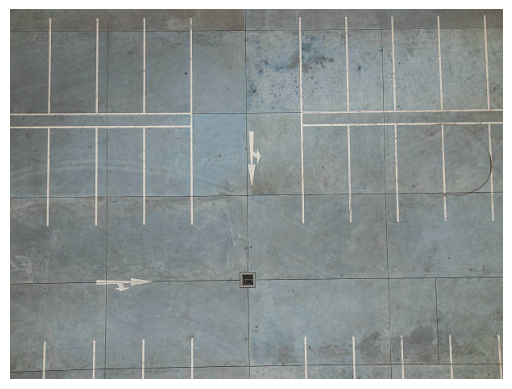

In [13]:
img = load_image(1)
plot_image(img)

/tmp/ipykernel_5484/3767165680.py:22: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  remove_objects = remove_small_holes(dilated1,1600,connectivity=2)


Box 0: Coordinates (6, 591, 124, 644), Width 53, Height 118
Box 1: Coordinates (7, 478, 126, 532), Width 54, Height 119
Box 2: Coordinates (7, 535, 125, 590), Width 55, Height 118
Box 3: Coordinates (8, 421, 124, 474), Width 53, Height 116
Box 4: Coordinates (9, 363, 127, 416), Width 53, Height 118
Box 5: Coordinates (10, 0, 127, 47), Width 47, Height 117
Box 6: Coordinates (10, 52, 127, 105), Width 53, Height 117
Box 7: Coordinates (10, 112, 126, 163), Width 51, Height 116
Box 8: Coordinates (10, 170, 126, 221), Width 51, Height 116
Box 9: Coordinates (145, 599, 263, 652), Width 53, Height 118
Box 10: Coordinates (146, 483, 266, 537), Width 54, Height 120
Box 11: Coordinates (146, 541, 264, 596), Width 55, Height 118
Box 12: Coordinates (147, 424, 266, 480), Width 56, Height 119
Box 13: Coordinates (148, 366, 266, 419), Width 53, Height 118
Box 14: Coordinates (150, 50, 270, 104), Width 54, Height 120
Box 15: Coordinates (150, 110, 270, 163), Width 53, Height 120
Box 16: Coordinates (

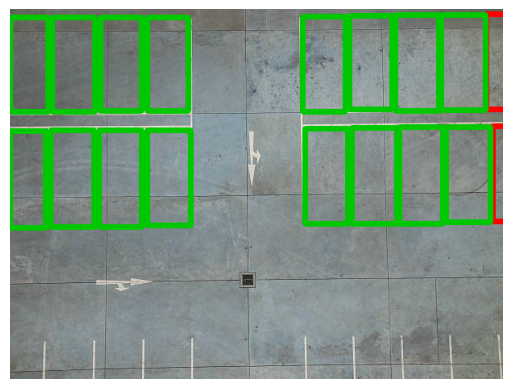

In [14]:
im1_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
m_blur = cv2.medianBlur(im1_gray,3)
b_blur = cv2.bilateralFilter(m_blur,d=2,sigmaColor=50,sigmaSpace=50)
canny_high = 200
canny_low = 100
edges = cv2.Canny(b_blur, canny_low,canny_high)
kernel = np.ones((3,3),np.uint8)
dilated = cv2.dilate(edges, kernel,iterations = 6)
kernel1 = np.ones((9,9),np.uint8)
eroded = cv2.erode(dilated,kernel1, iterations=1)
#Opening
kernel_open = np.ones((1,5),np.uint8)
opening = cv2.morphologyEx(eroded,cv2.MORPH_OPEN,kernel_open,iterations=1)

#Closing
kernel_close = np.ones((9,9),np.uint8)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE,kernel_close,iterations=1)

kernel = np.ones((1,1),np.uint8)
dilated1 = cv2.dilate(closing, kernel,iterations = 1)

remove_objects = remove_small_holes(dilated1,1600,connectivity=2)
remove_objects = remove_small_objects(remove_objects,1600,connectivity = 2).astype(np.uint8)

kernel_length = 13
kernel_horizontal = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length,1))
closing = cv2.morphologyEx(remove_objects, cv2.MORPH_CLOSE,kernel_horizontal,iterations = 8)

skeleton = skeletonize(closing).astype(np.uint8)
boundary = closing 
boundary_uint8 = img_as_ubyte(boundary)

subtracted_edges = cv2.subtract(boundary_uint8,remove_objects)

labeled_image = label(subtracted_edges>0)
regions = regionprops(labeled_image)
num_spaces = len(regions)


box_data,width_range,height_range,mode_height,mode_width = test_detection(regions=regions)

corrected_rectangle(img,edges,subtracted_edges,0.6,0,box_data,width_range,height_range,mode_height,mode_width)
#non_corrected_rectangle(img,edges,regions,subtracted_edges,0,1.2)

# Image 2, Set 1

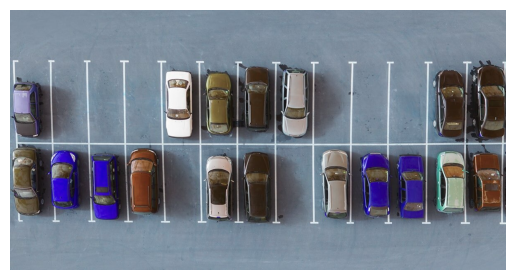

In [15]:
img = load_image(2)
plot_image(img)

/tmp/ipykernel_5484/3103488918.py:26: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  remove_objects = remove_small_holes(dilated1,1600,connectivity=2)


29
Box 0: Coordinates (120, 0, 318, 82), Width 82, Height 198
Box 1: Coordinates (120, 104, 319, 185), Width 81, Height 199
Box 2: Coordinates (121, 192, 320, 273), Width 81, Height 199
Box 3: Coordinates (121, 282, 321, 364), Width 82, Height 200
Box 4: Coordinates (121, 1142, 319, 1224), Width 82, Height 198
Box 5: Coordinates (121, 1107, 319, 1189), Width 82, Height 198
Box 6: Coordinates (122, 372, 321, 455), Width 83, Height 199
Box 7: Coordinates (123, 464, 321, 546), Width 82, Height 198
Box 8: Coordinates (123, 1111, 321, 1193), Width 82, Height 198
Box 9: Coordinates (124, 556, 321, 638), Width 82, Height 197
Box 10: Coordinates (124, 648, 322, 729), Width 81, Height 198
Box 11: Coordinates (124, 739, 322, 823), Width 84, Height 198
Box 12: Coordinates (124, 830, 322, 912), Width 82, Height 198
Box 13: Coordinates (124, 920, 321, 1006), Width 86, Height 197
Box 14: Coordinates (124, 1014, 320, 1100), Width 86, Height 196
Box 15: Coordinates (176, 384, 374, 466), Width 82, Heig

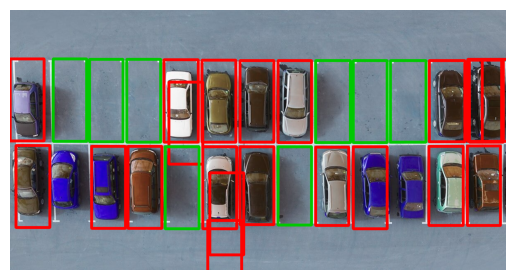

In [18]:
im1_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

m_blur = cv2.medianBlur(im1_gray,3)
b_blur = cv2.bilateralFilter(m_blur,d=2,sigmaColor=50,sigmaSpace=50)

canny_high = 200
canny_low = 100
edges = cv2.Canny(b_blur, canny_low,canny_high)

kernel = np.ones((3,3),np.uint8)
dilated = cv2.dilate(edges, kernel,iterations = 3)
kernel1 = np.ones((9,9),np.uint8)
eroded = cv2.erode(dilated,kernel1, iterations=1)

#Opening
kernel_open = np.ones((1,1),np.uint8)
opening = cv2.morphologyEx(eroded,cv2.MORPH_OPEN,kernel_open,iterations=1)

#Closing
kernel_close = np.ones((1,1),np.uint8)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE,kernel_close,iterations=1)

kernel = np.ones((5,5),np.uint8)
dilated1 = cv2.dilate(closing, kernel,iterations = 2)

remove_objects = remove_small_holes(dilated1,1600,connectivity=2)
remove_objects = remove_small_objects(remove_objects,1600,connectivity = 2).astype(np.uint8)

kernel_length = 15
kernel_horizontal = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length,1))
closing = cv2.morphologyEx(remove_objects, cv2.MORPH_CLOSE,kernel_horizontal,iterations = 14)

skeleton = skeletonize(closing).astype(np.uint8)
boundary = closing 
boundary_uint8 = img_as_ubyte(boundary)

subtracted_edges = cv2.subtract(boundary_uint8,remove_objects)
plot_image(subtracted_edges)

labeled_image = label(subtracted_edges>0)
regions = regionprops(labeled_image)
num_spaces = len(regions)
print(num_spaces)

box_data,width_range,height_range,mode_height,mode_width = test_detection(regions=regions)

corrected_rectangle(img,edges,subtracted_edges,1.2,0,box_data,width_range,height_range,mode_height,mode_width)
#non_corrected_rectangle(img,edges,regions,subtracted_edges,0,1.2)

# Image 3, Set 1

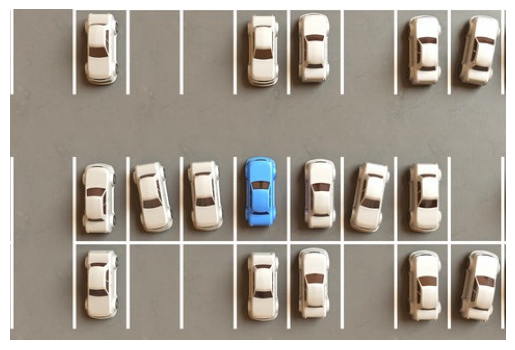

In [19]:
img = load_image(3)
plot_image(img)

/tmp/ipykernel_5484/3348815473.py:25: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  remove_objects = remove_small_holes(dilated1,1600,connectivity=2)


26
Box 0: Coordinates (1, 70, 81, 114), Width 44, Height 80
Box 1: Coordinates (1, 116, 81, 165), Width 49, Height 80
Box 2: Coordinates (1, 168, 81, 217), Width 49, Height 80
Box 3: Coordinates (1, 219, 81, 268), Width 49, Height 80
Box 4: Coordinates (1, 270, 81, 320), Width 50, Height 80
Box 5: Coordinates (1, 322, 81, 371), Width 49, Height 80
Box 6: Coordinates (1, 374, 81, 423), Width 49, Height 80
Box 7: Coordinates (32, 425, 112, 474), Width 49, Height 80
Box 8: Coordinates (44, 373, 124, 422), Width 49, Height 80
Box 9: Coordinates (143, 219, 225, 268), Width 49, Height 82
Box 10: Coordinates (144, 70, 225, 114), Width 44, Height 81
Box 11: Coordinates (144, 116, 225, 165), Width 49, Height 81
Box 12: Coordinates (144, 168, 225, 217), Width 49, Height 81
Box 13: Coordinates (144, 219, 224, 268), Width 49, Height 80
Box 14: Coordinates (144, 270, 224, 319), Width 49, Height 80
Box 15: Coordinates (144, 322, 225, 371), Width 49, Height 81
Box 16: Coordinates (144, 373, 225, 423)

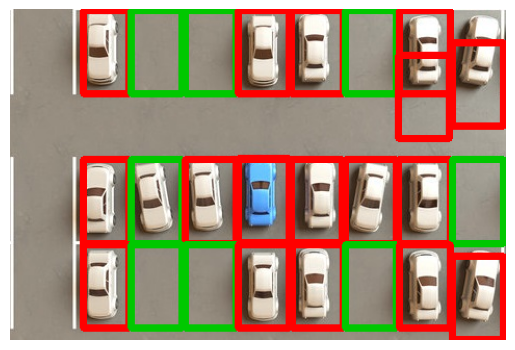

In [22]:
im1_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

m_blur = cv2.medianBlur(im1_gray,3)
b_blur = cv2.bilateralFilter(m_blur,d=2,sigmaColor=255,sigmaSpace=80)

canny_high = 100
canny_low = 20
edges = cv2.Canny(b_blur, canny_low,canny_high)

kernel = np.ones((3,4),np.uint8)
dilated = cv2.dilate(edges, kernel,iterations = 2)
kernel1 = np.ones((8,8),np.uint8)
eroded = cv2.erode(dilated,kernel1, iterations=1)

#Opening
kernel_open = np.ones((1,1),np.uint8)
opening = cv2.morphologyEx(eroded,cv2.MORPH_OPEN,kernel_open,iterations=1)

#Closing
kernel_close = np.ones((1,1),np.uint8)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE,kernel_close,iterations=1)
kernel = np.ones((1,1),np.uint8)
dilated1 = cv2.dilate(closing, kernel,iterations = 1)

remove_objects = remove_small_holes(dilated1,1600,connectivity=2)
remove_objects = remove_small_objects(remove_objects,1600,connectivity = 2).astype(np.uint8)

kernel_length = 8
kernel_horizontal = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length,1))
closing = cv2.morphologyEx(remove_objects, cv2.MORPH_CLOSE,kernel_horizontal,iterations = 8)

skeleton = skeletonize(closing).astype(np.uint8)
boundary = closing 
boundary_uint8 = img_as_ubyte(boundary)

subtracted_edges = cv2.subtract(boundary_uint8,remove_objects)
plot_image(subtracted_edges)

labeled_image = label(subtracted_edges>0)
regions = regionprops(labeled_image)
num_spaces = len(regions)
print(num_spaces)

box_data,width_range,height_range,mode_height,mode_width = test_detection(regions=regions)

corrected_rectangle(img,edges,subtracted_edges,1.2,0,box_data,width_range,height_range,mode_height,mode_width)
#non_corrected_rectangle(img,edges,regions,subtracted_edges,0,1.2)

# Image 4, Set 1

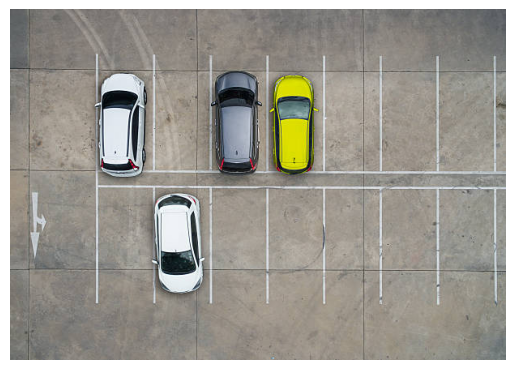

In [36]:
img = load_image(4)
img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
plot_image(img)

/tmp/ipykernel_5484/2358230351.py:22: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  remove_objects = remove_small_holes(dilated1,1600,connectivity=2)


16
Box 0: Coordinates (52, 116, 53, 130), Width 14, Height 1
Box 1: Coordinates (53, 154, 54, 168), Width 14, Height 1
Box 2: Coordinates (54, 392, 55, 406), Width 14, Height 1
Box 3: Coordinates (55, 462, 56, 476), Width 14, Height 1
Box 4: Coordinates (55, 532, 56, 546), Width 14, Height 1
Box 5: Coordinates (117, 333, 118, 347), Width 14, Height 1
Box 6: Coordinates (206, 116, 214, 128), Width 12, Height 8
Box 7: Coordinates (206, 356, 208, 370), Width 14, Height 2
Box 8: Coordinates (206, 371, 207, 385), Width 14, Height 1
Box 9: Coordinates (214, 214, 215, 219), Width 5, Height 1
Box 10: Coordinates (214, 249, 215, 263), Width 14, Height 1
Box 11: Coordinates (215, 116, 216, 130), Width 14, Height 1
Box 12: Coordinates (215, 471, 216, 486), Width 15, Height 1
Box 13: Coordinates (215, 498, 216, 512), Width 14, Height 1
Box 14: Coordinates (224, 322, 225, 336), Width 14, Height 1
Box 15: Coordinates (225, 533, 226, 547), Width 14, Height 1
Rectangle Status Dictionary:
Rectangle 0: 

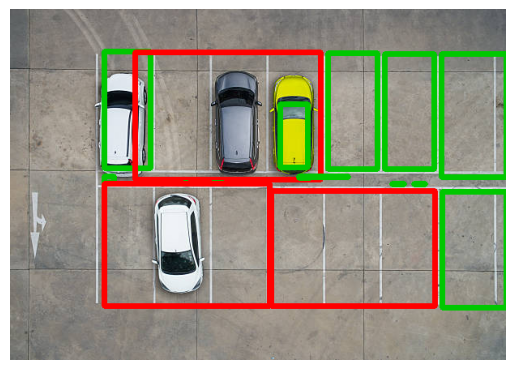

In [45]:
im1_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
m_blur = cv2.medianBlur(im1_gray,3)
b_blur = cv2.bilateralFilter(m_blur,d=3,sigmaColor=120,sigmaSpace=10)
canny_high = 200
canny_low = 100
edges = cv2.Canny(b_blur, canny_low,canny_high)
kernel = np.ones((3,3),np.uint8)
dilated = cv2.dilate(edges, kernel,iterations = 3)
kernel1 = np.ones((9,9),np.uint8)
eroded = cv2.erode(dilated,kernel1, iterations=1)
#Opening
kernel_open = np.ones((1,1),np.uint8)
opening = cv2.morphologyEx(eroded,cv2.MORPH_OPEN,kernel_open,iterations=1)

#Closing
kernel_close = np.ones((1,1),np.uint8)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE,kernel_close,iterations=1)

kernel = np.ones((5,5),np.uint8)
dilated1 = cv2.dilate(closing, kernel,iterations = 2)

remove_objects = remove_small_holes(dilated1,1600,connectivity=2)
remove_objects = remove_small_objects(remove_objects,1600,connectivity = 2).astype(np.uint8)

kernel_length = 16
kernel_horizontal = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length,1))
closing = cv2.morphologyEx(remove_objects, cv2.MORPH_CLOSE,kernel_horizontal,iterations = 14)

skeleton = skeletonize(closing).astype(np.uint8)
boundary = closing 
boundary_uint8 = img_as_ubyte(boundary)

subtracted_edges = cv2.subtract(boundary_uint8,remove_objects)

labeled_image = label(subtracted_edges>0)
regions = regionprops(labeled_image)
num_spaces = len(regions)
print(num_spaces)

box_data,width_range,height_range,mode_height,mode_width = test_detection(regions=regions)

#corrected_rectangle(img,edges,subtracted_edges,1.2,0,box_data,width_range,height_range,mode_height,mode_width)
non_corrected_rectangle(img,edges,regions,subtracted_edges,1,2.87)

# Image 5, Set 2

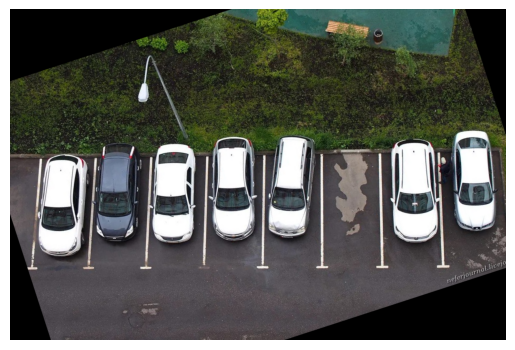

In [49]:
img = load_image(5)
img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
rotated_img = rotate_image(img,18)
plot_image(rotated_img)

/tmp/ipykernel_5484/2854441587.py:16: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  remove_objects1 = remove_small_holes(eroded,1600,connectivity=2)
/tmp/ipykernel_5484/2854441587.py:31: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  remove_objects = remove_small_holes(dilated1,15000,connectivity=2)


11
Box 0: Coordinates (277, 993, 536, 1100), Width 107, Height 259
Box 1: Coordinates (280, 511, 539, 618), Width 107, Height 259
Box 2: Coordinates (308, 930, 567, 1037), Width 107, Height 259
Box 3: Coordinates (317, 826, 576, 933), Width 107, Height 259
Box 4: Coordinates (318, 308, 577, 415), Width 107, Height 259
Box 5: Coordinates (318, 696, 577, 803), Width 107, Height 259
Box 6: Coordinates (320, 75, 579, 182), Width 107, Height 259
Box 7: Coordinates (321, 0, 580, 107), Width 107, Height 259
Box 8: Coordinates (424, 436, 683, 543), Width 107, Height 259
Box 9: Coordinates (576, 956, 835, 1063), Width 107, Height 259
Box 10: Coordinates (577, 693, 836, 800), Width 107, Height 259
Rectangle Status Dictionary:
Rectangle 0: {'coordinates': (993, 277, 1100, 495), 'edge_count': 20437, 'status': 'Occupied'}
Rectangle 1: {'coordinates': (511, 280, 686, 516), 'edge_count': 28541, 'status': 'Occupied'}
Rectangle 2: {'coordinates': (930, 308, 1023, 576), 'edge_count': 11386, 'status': 'O

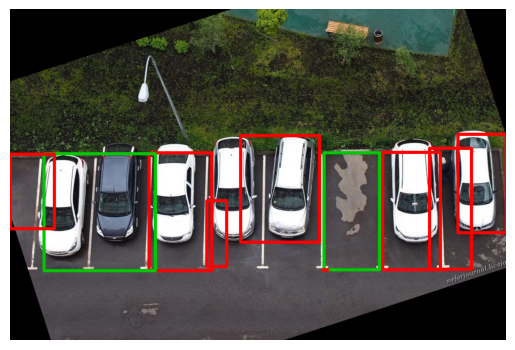

In [53]:
im1_gray = cv2.cvtColor(rotated_img,cv2.COLOR_RGB2GRAY)

m_blur = cv2.medianBlur(im1_gray,3)
b_blur = cv2.bilateralFilter(m_blur,d=3,sigmaColor=120,sigmaSpace=10)

canny_high = 200
canny_low = 100
edges = cv2.Canny(b_blur, canny_low,canny_high)

kernel = np.ones((3,3),np.uint8)
dilated = cv2.dilate(edges, kernel,iterations = 3)
kernel1 = np.ones((9,9),np.uint8)
eroded = cv2.erode(dilated,kernel1, iterations=1)
#plot_image(eroded)

remove_objects1 = remove_small_holes(eroded,1600,connectivity=2)
remove_objects1 = remove_small_objects(remove_objects1,1000,connectivity = 1).astype(np.uint8)
#plot_image(remove_objects1)

#Opening
kernel_open = np.ones((1,1),np.uint8)
opening = cv2.morphologyEx(remove_objects1,cv2.MORPH_OPEN,kernel_open,iterations=1)

#Closing
kernel_close = np.ones((1,1),np.uint8)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE,kernel_close,iterations=1)

kernel = np.ones((5,5),np.uint8)
dilated1 = cv2.dilate(closing, kernel,iterations = 2)

remove_objects = remove_small_holes(dilated1,15000,connectivity=2)
remove_objects = remove_small_objects(remove_objects,3450,connectivity = 2).astype(np.uint8)
#plot_image(remove_objects)

kernel_length = 16
kernel_horizontal = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length,1))
closing = cv2.morphologyEx(remove_objects, cv2.MORPH_CLOSE,kernel_horizontal,iterations = 14)
#plot_image(closing)

skeleton = skeletonize(closing).astype(np.uint8)
boundary = closing
boundary_uint8 = img_as_ubyte(boundary)
#plot_image(boundary_uint8)

subtracted_edges = cv2.subtract(boundary_uint8,remove_objects)
#plot_image(subtracted_edges)

labeled_image = label(subtracted_edges>0)
regions = regionprops(labeled_image)
num_spaces = len(regions)
print(num_spaces)

box_data,width_range,height_range,mode_height,mode_width = test_detection(regions=regions)

#corrected_rectangle(rotated_img,edges,subtracted_edges,box_data,width_range,height_range,mode_height,mode_width)
non_corrected_rectangle(rotated_img,edges,regions,subtracted_edges,0,1.6)

# Image 6, Set 2

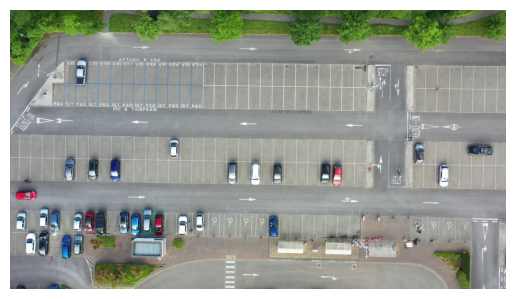

In [61]:
img = load_image(6)
img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
plot_image(img)

/tmp/ipykernel_5484/3340953242.py:26: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  remove_objects = remove_small_holes(dilated1,1600,connectivity=2)


441
Box 0: Coordinates (0, 1383, 1, 1465), Width 82, Height 1
Box 1: Coordinates (0, 1894, 1, 1976), Width 82, Height 1
Box 2: Coordinates (0, 2077, 1, 2159), Width 82, Height 1
Box 3: Coordinates (0, 2473, 1, 2555), Width 82, Height 1
Box 4: Coordinates (0, 2973, 1, 3055), Width 82, Height 1
Box 5: Coordinates (1, 1373, 2, 1455), Width 82, Height 1
Box 6: Coordinates (1, 1588, 2, 1670), Width 82, Height 1
Box 7: Coordinates (1, 1725, 2, 1807), Width 82, Height 1
Box 8: Coordinates (2, 1136, 3, 1218), Width 82, Height 1
Box 9: Coordinates (19, 1009, 20, 1091), Width 82, Height 1
Box 10: Coordinates (19, 2018, 20, 2100), Width 82, Height 1
Box 11: Coordinates (22, 2934, 23, 3016), Width 82, Height 1
Box 12: Coordinates (26, 2835, 27, 2917), Width 82, Height 1
Box 13: Coordinates (26, 2750, 27, 2832), Width 82, Height 1
Box 14: Coordinates (30, 2452, 31, 2534), Width 82, Height 1
Box 15: Coordinates (30, 2832, 31, 2914), Width 82, Height 1
Box 16: Coordinates (32, 194, 33, 276), Width 82

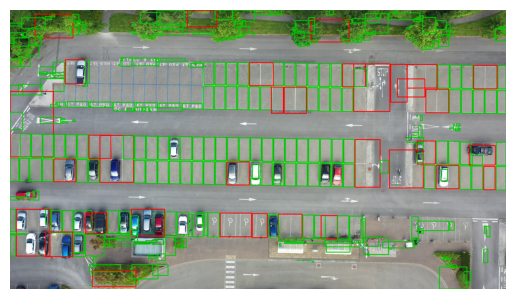

In [67]:
im1_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

m_blur = cv2.medianBlur(im1_gray,3)
b_blur = cv2.bilateralFilter(m_blur,d=3,sigmaColor=120,sigmaSpace=10)

canny_high = 200
canny_low = 100
edges = cv2.Canny(b_blur, canny_low,canny_high)

kernel = np.ones((3,3),np.uint8)
dilated = cv2.dilate(edges, kernel,iterations = 3)
kernel1 = np.ones((9,9),np.uint8)
eroded = cv2.erode(dilated,kernel1, iterations=1)

#Opening
kernel_open = np.ones((1,1),np.uint8)
opening = cv2.morphologyEx(eroded,cv2.MORPH_OPEN,kernel_open,iterations=1)

#Closing
kernel_close = np.ones((1,1),np.uint8)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE,kernel_close,iterations=1)

kernel = np.ones((5,5),np.uint8)
dilated1 = cv2.dilate(closing, kernel,iterations = 2)

remove_objects = remove_small_holes(dilated1,1600,connectivity=2)
remove_objects = remove_small_objects(remove_objects,1600,connectivity = 2).astype(np.uint8)

kernel_length = 16
kernel_horizontal = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length,1))
closing = cv2.morphologyEx(remove_objects, cv2.MORPH_CLOSE,kernel_horizontal,iterations = 14)
plot_image(closing)

skeleton = skeletonize(closing).astype(np.uint8)
boundary = closing 
boundary_uint8 = img_as_ubyte(boundary)
plot_image(boundary_uint8)

subtracted_edges = cv2.subtract(boundary_uint8,remove_objects)
plot_image(subtracted_edges)

labeled_image = label(subtracted_edges>0)
regions = regionprops(labeled_image)
num_spaces = len(regions)
print(num_spaces)

box_data,width_range,height_range,mode_height,mode_width = test_detection(regions=regions)

#corrected_rectangle(img,edges,subtracted_edges,box_data,width_range,height_range,mode_height,mode_width)
non_corrected_rectangle(img,edges,regions,subtracted_edges,1,2.5)

# Image 7, Set 2

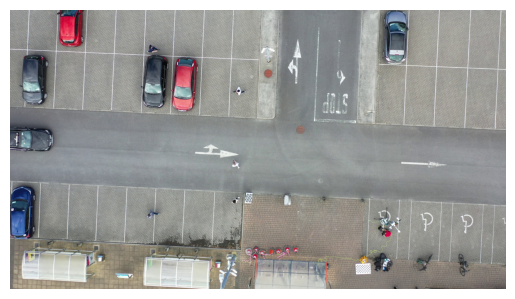

In [71]:
img = load_image(7)
img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
plot_image(img)

/tmp/ipykernel_5484/2689690866.py:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  remove_objects1 = remove_small_holes(eroded,1600,connectivity=2)
/tmp/ipykernel_5484/2689690866.py:34: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  remove_objects = remove_small_holes(dilated1,1600,connectivity=2)


44
Box 0: Coordinates (0, 0, 433, 192), Width 192, Height 433
Box 1: Coordinates (0, 167, 433, 359), Width 192, Height 433
Box 2: Coordinates (0, 615, 433, 807), Width 192, Height 433
Box 3: Coordinates (0, 839, 433, 1031), Width 192, Height 433
Box 4: Coordinates (0, 814, 433, 1006), Width 192, Height 433
Box 5: Coordinates (0, 1520, 433, 1712), Width 192, Height 433
Box 6: Coordinates (0, 3101, 433, 3293), Width 192, Height 433
Box 7: Coordinates (0, 3335, 433, 3527), Width 192, Height 433
Box 8: Coordinates (0, 3576, 433, 3768), Width 192, Height 433
Box 9: Coordinates (0, 3810, 433, 4002), Width 192, Height 433
Box 10: Coordinates (56, 1747, 489, 1939), Width 192, Height 433
Box 11: Coordinates (342, 0, 775, 192), Width 192, Height 433
Box 12: Coordinates (349, 159, 782, 351), Width 192, Height 433
Box 13: Coordinates (351, 1828, 784, 2020), Width 192, Height 433
Box 14: Coordinates (359, 366, 789, 560), Width 194, Height 430
Box 15: Coordinates (369, 592, 802, 784), Width 192, Hei

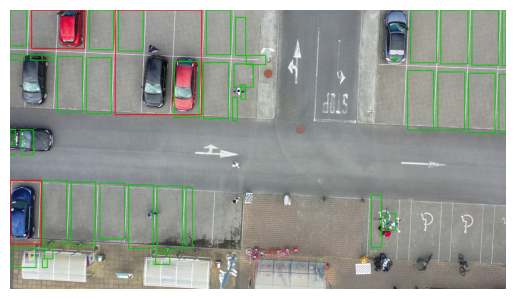

In [72]:
im1_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

m_blur = cv2.medianBlur(im1_gray,7)
b_blur = cv2.bilateralFilter(m_blur,d=3,sigmaColor=120,sigmaSpace=10)

canny_high = 200
canny_low = 100
edges = cv2.Canny(b_blur, canny_low,canny_high)

kernel = np.ones((3,3),np.uint8)
dilated = cv2.dilate(edges, kernel,iterations = 3)
kernel1 = np.ones((9,9),np.uint8)
eroded = cv2.erode(dilated,kernel1, iterations=1)

remove_objects1 = remove_small_holes(eroded,1600,connectivity=2)
remove_objects1 = remove_small_objects(remove_objects1,400,connectivity = 2).astype(np.uint8)
plot_image(remove_objects1)

#Opening
kernel_open = np.ones((1,1),np.uint8)
opening = cv2.morphologyEx(remove_objects1,cv2.MORPH_OPEN,kernel_open,iterations=1)

#Closing
kernel_close = np.ones((1,1),np.uint8)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE,kernel_close,iterations=1)

#cleaned = morphology.remove_small_objects(opening, min_size = 62, connectivity = 2)
#plotting the image
plot_image(closing)

kernel = np.ones((8,6),np.uint8)
dilated1 = cv2.dilate(closing, kernel,iterations = 9)

remove_objects = remove_small_holes(dilated1,1600,connectivity=2)
remove_objects = remove_small_objects(remove_objects,12000,connectivity = 1).astype(np.uint8)
plot_image(remove_objects)

kernel_length = 20
kernel_horizontal = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length,1))
closing = cv2.morphologyEx(remove_objects, cv2.MORPH_CLOSE,kernel_horizontal,iterations = 30)
plot_image(closing)

skeleton = skeletonize(closing).astype(np.uint8)
boundary = closing 
boundary_uint8 = img_as_ubyte(boundary)
plot_image(boundary_uint8)

subtracted_edges = cv2.subtract(boundary_uint8,remove_objects)
plot_image(subtracted_edges)

labeled_image = label(subtracted_edges>0)
regions = regionprops(labeled_image)
num_spaces = len(regions)
print(num_spaces)

box_data,width_range,height_range,mode_height,mode_width = test_detection(regions=regions)

#corrected_rectangle(img,edges,subtracted_edges,box_data,width_range,height_range,mode_height,mode_width)
non_corrected_rectangle(img,edges,regions,subtracted_edges,1,1.8)

# Image 8, Set 3

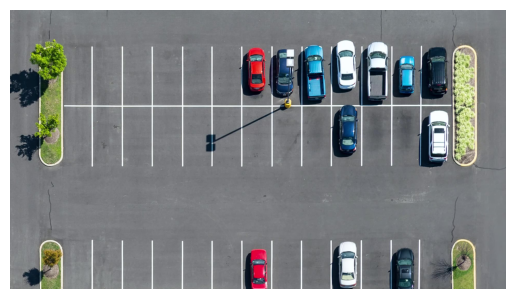

In [73]:
img = load_image(8)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plot_image(img)

/tmp/ipykernel_5484/551084990.py:15: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  remove_objects1 = remove_small_holes(eroded,7000,connectivity=2)
/tmp/ipykernel_5484/551084990.py:29: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  remove_objects = remove_small_holes(dilated1,9000,connectivity=1)


24
Rectangle Status Dictionary:
Rectangle 0: {'coordinates': (1270, 121, 1458, 350), 'edge_count': 21667, 'status': 'Occupied'}
Rectangle 1: {'coordinates': (342, 122, 414, 350), 'edge_count': 15953, 'status': 'Free'}
Rectangle 2: {'coordinates': (459, 122, 648, 350), 'edge_count': 31630, 'status': 'Occupied'}
Rectangle 3: {'coordinates': (692, 122, 764, 350), 'edge_count': 15054, 'status': 'Free'}
Rectangle 4: {'coordinates': (806, 122, 880, 350), 'edge_count': 15667, 'status': 'Free'}
Rectangle 5: {'coordinates': (1824, 140, 1920, 606), 'edge_count': 42063, 'status': 'Occupied'}
Rectangle 6: {'coordinates': (1503, 149, 1695, 347), 'edge_count': 29864, 'status': 'Occupied'}
Rectangle 7: {'coordinates': (1744, 170, 1788, 574), 'edge_count': 10940, 'status': 'Free'}
Rectangle 8: {'coordinates': (227, 219, 296, 349), 'edge_count': 8914, 'status': 'Free'}
Rectangle 9: {'coordinates': (922, 238, 997, 350), 'edge_count': 6775, 'status': 'Free'}
Rectangle 10: {'coordinates': (1039, 247, 1228

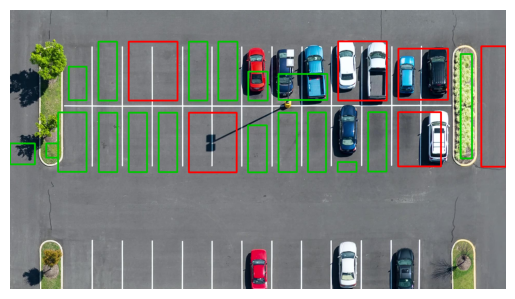

In [81]:
im1_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

m_blur = cv2.medianBlur(im1_gray,5)
b_blur = cv2.bilateralFilter(m_blur,d=15,sigmaColor=100,sigmaSpace=10)

canny_high = 200
canny_low = 100
edges = cv2.Canny(b_blur, canny_low,canny_high)

kernel = np.ones((4,4),np.uint8)
dilated = cv2.dilate(edges, kernel,iterations = 3)
kernel1 = np.ones((9,9),np.uint8)
eroded = cv2.erode(dilated,kernel1, iterations=1)

remove_objects1 = remove_small_holes(eroded,7000,connectivity=2)
remove_objects1 = remove_small_objects(remove_objects1,12000,connectivity = 2).astype(np.uint8)

#Opening
kernel_open = np.ones((1,1),np.uint8)
opening = cv2.morphologyEx(remove_objects1,cv2.MORPH_OPEN,kernel_open,iterations=1)

#Closing
kernel_close = np.ones((1,1),np.uint8)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE,kernel_close,iterations=1)

kernel = np.ones((9,9),np.uint8)
dilated1 = cv2.dilate(closing, kernel,iterations = 5)

remove_objects = remove_small_holes(dilated1,9000,connectivity=1)
remove_objects = remove_small_objects(remove_objects,1600,connectivity = 2).astype(np.uint8)

kernel_length = 13
kernel_horizontal = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length,1))
closing = cv2.morphologyEx(remove_objects, cv2.MORPH_CLOSE,kernel_horizontal,iterations = 16)

skeleton = skeletonize(closing).astype(np.uint8)
boundary = closing 
boundary_uint8 = img_as_ubyte(boundary)

subtracted_edges = cv2.subtract(boundary_uint8,remove_objects)

labeled_image = label(subtracted_edges>0)
regions = regionprops(labeled_image)
num_spaces = len(regions)
print(num_spaces)

#corrected_rectangle(img,edges,subtracted_edges,1.2,box_data,width_range,height_range,mode_height,mode_width)
non_corrected_rectangle(img,edges,regions,subtracted_edges,1,1.01)


# Image 10, Set 3

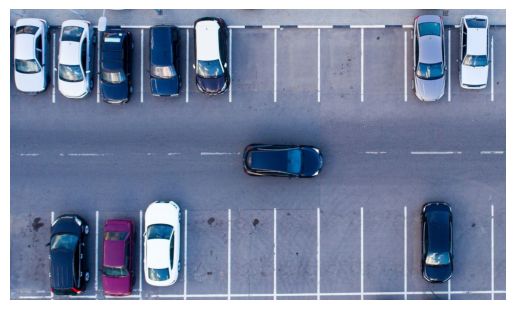

In [86]:
img = load_image(10)
img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
plot_image(img)

/tmp/ipykernel_5484/392106161.py:23: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  remove_objects1 = remove_small_holes(closing,500,connectivity=2)
/tmp/ipykernel_5484/392106161.py:29: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  remove_objects = remove_small_holes(dilated1,1600,connectivity=2)


17
Rectangle Status Dictionary:
Rectangle 0: {'coordinates': (510, 23, 623, 268), 'edge_count': 24525, 'status': 'Occupied'}
Rectangle 1: {'coordinates': (885, 26, 1246, 267), 'edge_count': 69119, 'status': 'Free'}
Rectangle 2: {'coordinates': (633, 44, 874, 267), 'edge_count': 48909, 'status': 'Free'}
Rectangle 3: {'coordinates': (381, 50, 500, 268), 'edge_count': 25133, 'status': 'Occupied'}
Rectangle 4: {'coordinates': (256, 58, 370, 269), 'edge_count': 23131, 'status': 'Occupied'}
Rectangle 5: {'coordinates': (1256, 58, 1412, 265), 'edge_count': 29691, 'status': 'Free'}
Rectangle 6: {'coordinates': (0, 67, 121, 269), 'edge_count': 20395, 'status': 'Occupied'}
Rectangle 7: {'coordinates': (130, 67, 247, 269), 'edge_count': 20500, 'status': 'Occupied'}
Rectangle 8: {'coordinates': (1379, 553, 1412, 803), 'edge_count': 7957, 'status': 'Occupied'}
Rectangle 9: {'coordinates': (1132, 558, 1369, 806), 'edge_count': 57463, 'status': 'Free'}
Rectangle 10: {'coordinates': (883, 561, 996, 80

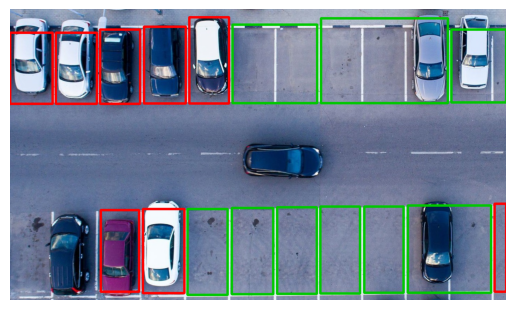

In [97]:
im1_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

m_blur = cv2.medianBlur(im1_gray,3)
b_blur = cv2.bilateralFilter(m_blur,d=6,sigmaColor=220,sigmaSpace=40)

canny_high = 200
canny_low = 100
edges = cv2.Canny(b_blur, canny_low,canny_high)

kernel = np.ones((3,3),np.uint8)
dilated = cv2.dilate(edges, kernel,iterations = 3)
kernel1 = np.ones((9,9),np.uint8)
eroded = cv2.erode(dilated,kernel1, iterations=1)

#Opening
kernel_open = np.ones((1,1),np.uint8)
opening = cv2.morphologyEx(eroded,cv2.MORPH_OPEN,kernel_open,iterations=1)

#Closing
kernel_close = np.ones((1,1),np.uint8)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE,kernel_close,iterations=1)

remove_objects1 = remove_small_holes(closing,500,connectivity=2)
remove_objects1 = remove_small_objects(remove_objects1,800,connectivity = 2).astype(np.uint8)

kernel = np.ones((5,5),np.uint8)
dilated1 = cv2.dilate(remove_objects1, kernel,iterations = 2)

remove_objects = remove_small_holes(dilated1,1600,connectivity=2)
remove_objects = remove_small_objects(remove_objects,500,connectivity = 2).astype(np.uint8)

kernel_length = 16
kernel_horizontal = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length,1))
closing = cv2.morphologyEx(remove_objects, cv2.MORPH_CLOSE,kernel_horizontal,iterations = 20)

skeleton = skeletonize(closing).astype(np.uint8)
boundary = closing 
boundary_uint8 = img_as_ubyte(boundary)

subtracted_edges = cv2.subtract(boundary_uint8,remove_objects)

labeled_image = label(subtracted_edges>0)
regions = regionprops(labeled_image)
num_spaces = len(regions)
print(num_spaces)


#corrected_rectangle(img,edges,subtracted_edges,1.12,1,box_data,width_range,height_range,mode_height,mode_width)
non_corrected_rectangle(img,edges,regions,subtracted_edges,0,0.87)